## POSTPROECESSING

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# !pip install leidenalg==0.7.0

In [41]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from MODULES.utilities import load_obj
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [42]:
def do_resolution_sweep(g, res_range, cpm_or_modularity, each_cc_separately):
    video_list, title_list, ncell_list, iou_list, resolution_list, mi_list, sizes_list = [], [], [], [], [], [], []
    for r in res_range:
        partition = g.find_partition_leiden(resolution=r, 
                                            cpm_or_modularity=cpm_or_modularity,
                                            each_cc_separately=each_cc_separately,
                                            min_size=10)
        concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
        
        mi_list.append(concordance.mutual_information)
        iou_list.append(concordance.iou)
        seg_mask = g.partition_2_mask(partition)
        video_list.append(seg_mask)
        resolution_list.append(r)
        ncell_list.append(len(partition.sizes)-1)
        sizes_list.append(partition.sizes.cpu().numpy())
        
    video = torch.stack(video_list, dim=0).cpu().numpy()

    mydict = {"video": video, 
              "ref_image": g.raw_image[0].cpu().numpy(), 
              "resolution_list": resolution_list, 
              "ncell_list": ncell_list,
              "mi_list": mi_list,
              "iou_list": iou_list,
              "sizes_list": sizes_list}
    return mydict

In [43]:
def show_video(dictionary: dict,
        figsize: Tuple[int, int] = (8, 4),
        interval: int = 50,
        nbins=10,
        hist_range=(0,200)):
    """
    :param video: an ndarray with shape (n_frames, height, width)
    :param title: an list of lenght (n_frames)    
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(dictionary["video"][0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(dictionary["ref_image"], cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(dictionary["resolution_list"], dictionary["ncell_list"], '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(dictionary["resolution_list"], dictionary["iou_list"], '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # hist
    _ = ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(dictionary["video"][0, ...])
        ax_video.set_title("title")
        ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'frame={0:3d} res={1:.3f} ncell={2:2d}'.format(i,dictionary["resolution_list"][i],
                                                               dictionary["ncell_list"][i])
        ax_video.imshow(skimage.color.label2rgb(dictionary["video"][i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(dictionary["sizes_list"][i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=dictionary["video"].shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

In [44]:
def plot_overlay(seg_mask: numpy.ndarray, raw_image: numpy.ndarray, figsize: tuple = (24,24)):
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(skimage.color.label2rgb(label=seg_mask, bg_label=0))
    ax[1].imshow(skimage.color.label2rgb(label=seg_mask, image=raw_image, alpha=0.25, bg_label=0))
    ax[2].imshow(raw_image, cmap='gray')

In [45]:
def plot_comparison(keys, dict1: dict, dict2: Optional[dict]=None, dict3: Optional[dict]=None, dict4: Optional[dict]=None):

    fig, axs = plt.subplots(figsize=(12,6))
    
    axs.plot(dict1["resolution_list"],dict1[keys], '-', label="dict1",color="blue")
    
    if dict2 is not None:
        axs.plot(dict2["resolution_list"],dict2[keys], 'x--', label="dict2",color="red")
    if dict3 is not None:
        axs.plot(dict3["resolution_list"],dict3[keys], 'o-', label="dict3",color="green") 
    if dict4 is not None:
        axs.plot(dict4["resolution_list"],dict4[keys], '.--', label="dict4",color="black")
    
    axs.set_xlabel('resolution parameter')
    axs.set_ylabel(keys)
    axs.grid()
    axs.legend()

# Import files

In [55]:
#tiling_file = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1/tiling_aug7_radius5.pt"
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_aug_5_v1/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_segment_june27_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v6/tiling.pt"
tiling_file_small = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100.pt"
tiling_file_large = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100_LARGE.pt"

# Comparison of criteria using small images

Text(0.5, 1.0, 'sample segmentation')

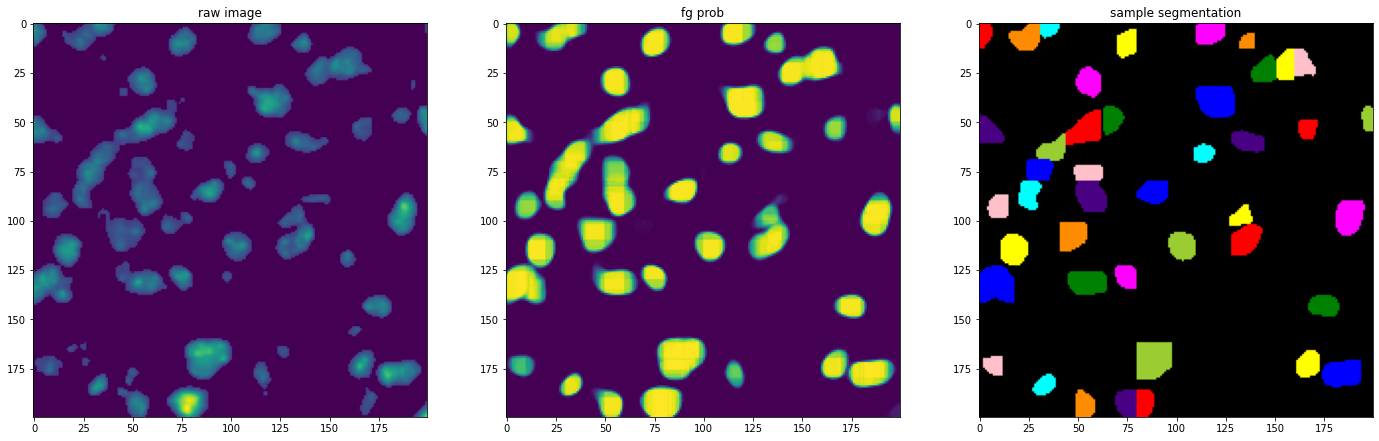

In [57]:
tiling_small = load_obj(tiling_file_small)

min_row, min_col, max_row, max_col = None,None,None,None #40,60,80,100
fig, axs = plt.subplots(ncols=3, figsize=(24,24))

axs[0].imshow(tiling_small.raw_image[0,0,min_row:max_row, min_col:max_col].cpu())
axs[1].imshow(tiling_small.fg_prob[0,0,min_row:max_row, min_col:max_col].cpu())
axs[2].imshow(skimage.color.label2rgb(tiling_small.integer_mask[0,0,min_row:max_row, min_col:max_col].cpu().numpy(), bg_label=0), aspect='equal')
axs[0].set_title("raw image")
axs[1].set_title("fg prob")
axs[2].set_title("sample segmentation")

In [58]:
g_small = GraphSegmentation(tiling_small, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)

sweep_cpm_normalized = do_resolution_sweep(g_small, res_range=numpy.arange(0.5,10,0.25), cpm_or_modularity="cpm", each_cc_separately=False)
sweep_modularity_normalized = do_resolution_sweep(g_small, res_range=numpy.arange(0.5,10,0.25), cpm_or_modularity="modularity", each_cc_separately=False)

cuda:0
cuda:0
Done building the graph


In [59]:
show_video(dictionary=sweep_cpm_normalized, interval=500, nbins=50, hist_range=(0,600))

In [60]:
show_video(dictionary=sweep_modularity_normalized, interval=500, nbins=50, hist_range=(0,600))

In [61]:
sweep_cpm_normalized.keys()

dict_keys(['video', 'ref_image', 'resolution_list', 'ncell_list', 'mi_list', 'iou_list', 'sizes_list'])

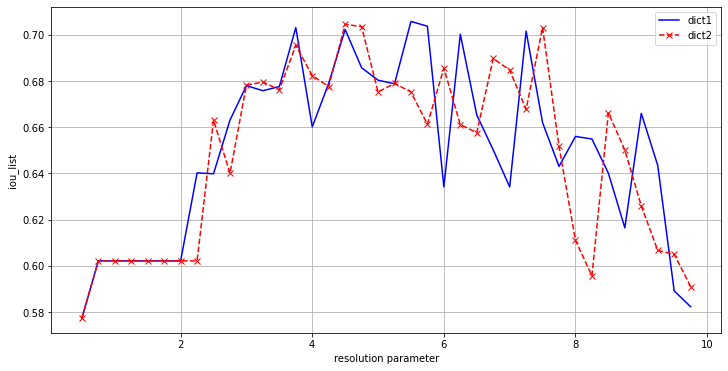

In [62]:
plot_comparison(keys='iou_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)

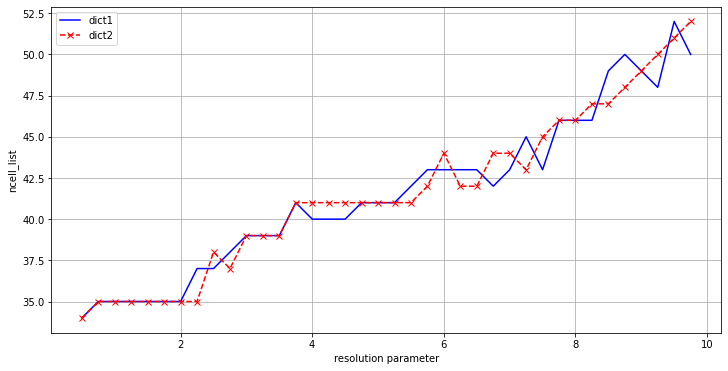

In [63]:
plot_comparison(keys='ncell_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)
#plot_comparison(keys='mi_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)

# Suggest the resolution parameter 

resolution sweep,   1 out of  45
resolution sweep,   2 out of  45
resolution sweep,   3 out of  45
resolution sweep,   4 out of  45
resolution sweep,   5 out of  45
resolution sweep,   6 out of  45
resolution sweep,   7 out of  45
resolution sweep,   8 out of  45
resolution sweep,   9 out of  45
resolution sweep,  10 out of  45
resolution sweep,  11 out of  45
resolution sweep,  12 out of  45
resolution sweep,  13 out of  45
resolution sweep,  14 out of  45
resolution sweep,  15 out of  45
resolution sweep,  16 out of  45
resolution sweep,  17 out of  45
resolution sweep,  18 out of  45
resolution sweep,  19 out of  45
resolution sweep,  20 out of  45
resolution sweep,  21 out of  45
resolution sweep,  22 out of  45
resolution sweep,  23 out of  45
resolution sweep,  24 out of  45
resolution sweep,  25 out of  45
resolution sweep,  26 out of  45
resolution sweep,  27 out of  45
resolution sweep,  28 out of  45
resolution sweep,  29 out of  45
resolution sweep,  30 out of  45
resolution

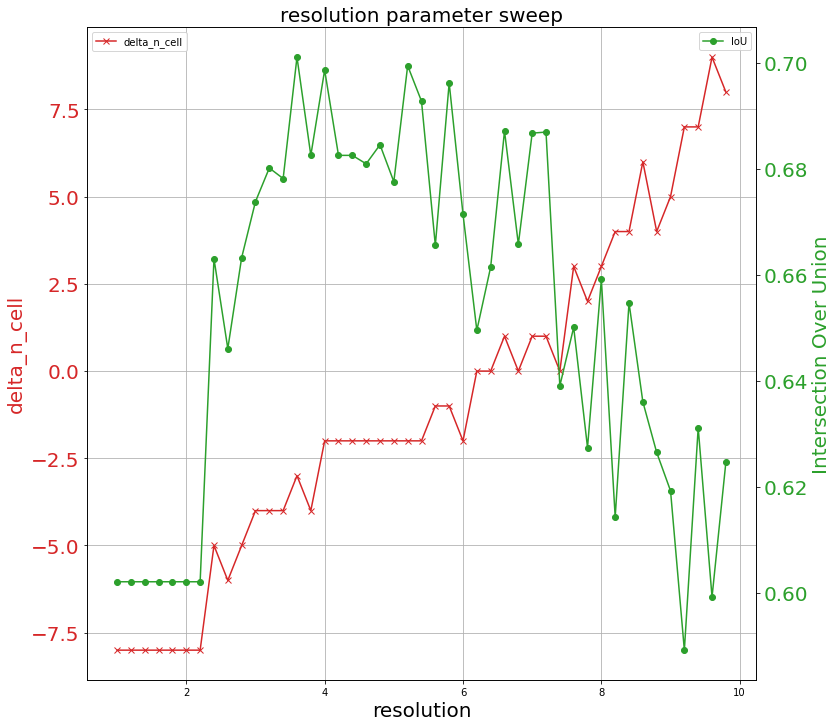

In [64]:
suggestion = g_small.suggest_resolution_parameter(window = None, #(min_row, min_col, max_row, max_col),
                                            min_size = 10,
                                            max_size = None,
                                            cpm_or_modularity = "modularity",
                                            each_cc_separately = False,
                                            show_graph = True,
                                            figsize = (12, 12),
                                            fontsize = 20,
                                            sweep_range = numpy.arange(1.0,10,0.2)) 

In [36]:
suggestion._fields

('best_resolution',
 'best_index',
 'sweep_resolution',
 'sweep_iou',
 'sweep_delta_n',
 'sweep_seg_mask')

RESOLUTION PARAMETER 7.599999999999999


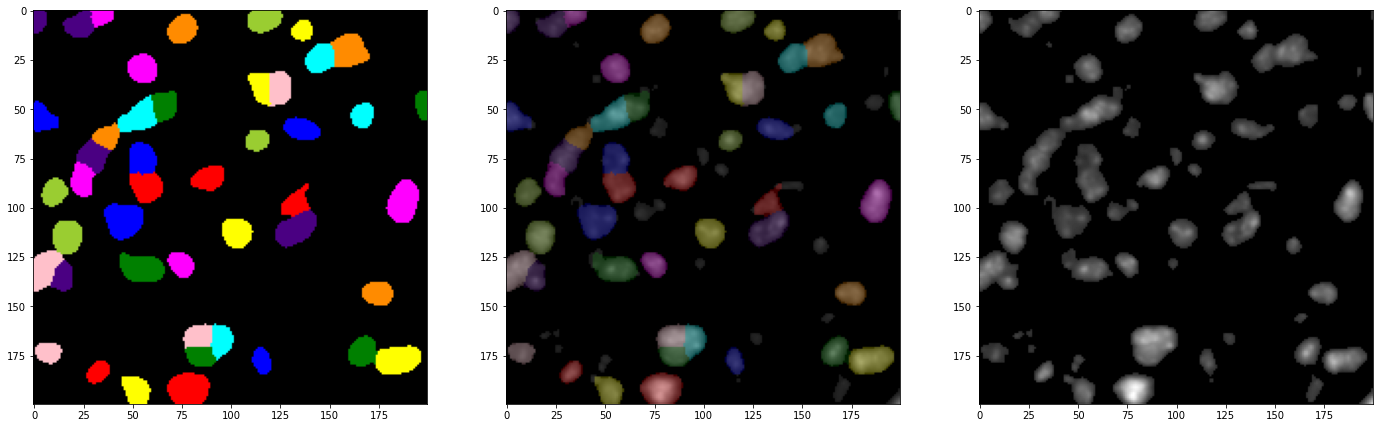

In [69]:
index=33
plot_overlay(seg_mask=suggestion.sweep_seg_mask[index], 
             raw_image=tiling_small.raw_image[0,0].cpu().numpy())

print("RESOLUTION PARAMETER", suggestion.sweep_resolution[index])